#**Import library**

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import GRU
from sklearn.metrics import mean_squared_error, mean_absolute_error




# **Load data and perfom Stationary**

In [ ]:


# Load the datasets
amzn_df = pd.read_csv("AMZN.csv", parse_dates=['Date'], index_col='Date')
jj_df = pd.read_csv("jj.csv", parse_dates=['date'], index_col='date')

# Select the relevant columns for analysis
amzn_series = amzn_df['Close'].dropna()
jj_series = jj_df['data'].dropna()

# Perform Augmented Dickey-Fuller test to check stationarity
def check_stationarity(series, name):
    result = adfuller(series)
    return {
        'Dataset': name,
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Stationary': result[1] < 0.05
    }

# First check
amzn_stationarity = check_stationarity(amzn_series, "AMZN - Original")
jj_stationarity = check_stationarity(jj_series, "JJ - Original")

# Apply differencing if needed
amzn_diff = amzn_series.diff().dropna()
jj_diff = jj_series.diff().dropna()

amzn_stationarity_diff1 = check_stationarity(amzn_diff, "AMZN - 1st Difference")
jj_stationarity_diff1 = check_stationarity(jj_diff, "JJ - 1st Difference")

# If still not stationary, apply second differencing
jj_diff2 = jj_diff.diff().dropna()
jj_stationarity_diff2 = check_stationarity(jj_diff2, "JJ - 2nd Difference")

# Combine results
stationarity_results = pd.DataFrame([
    amzn_stationarity,
    amzn_stationarity_diff1,
    jj_stationarity,
    jj_stationarity_diff1,
    jj_stationarity_diff2
])

stationarity_results


,Dataset,ADF Statistic,p-value,Stationary
0,AMZN - Original,-1.657809,0.452971,False
1,AMZN - 1st Difference,-36.250779,0.000000,True
2,JJ - Original,2.742017,1.000000,False
3,JJ - 1st Difference,-0.407410,0.908854,False
4,JJ - 2nd Difference,-3.585163,0.006051,True


**Perform analysiss before and after difference**

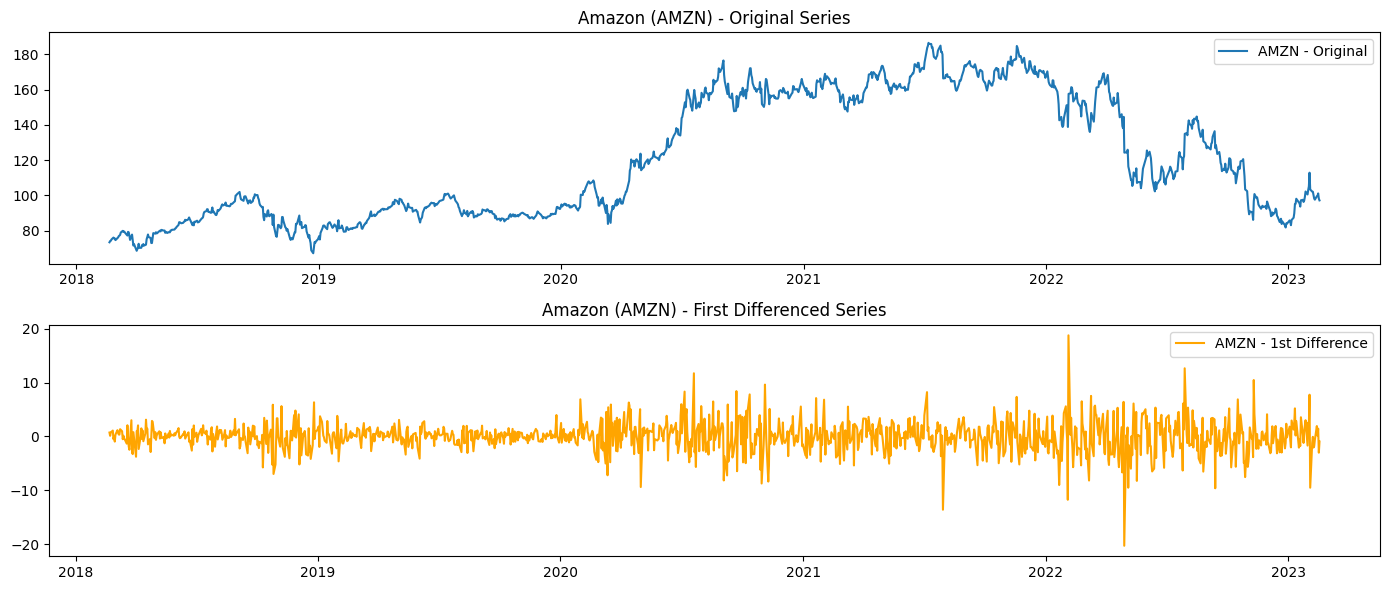

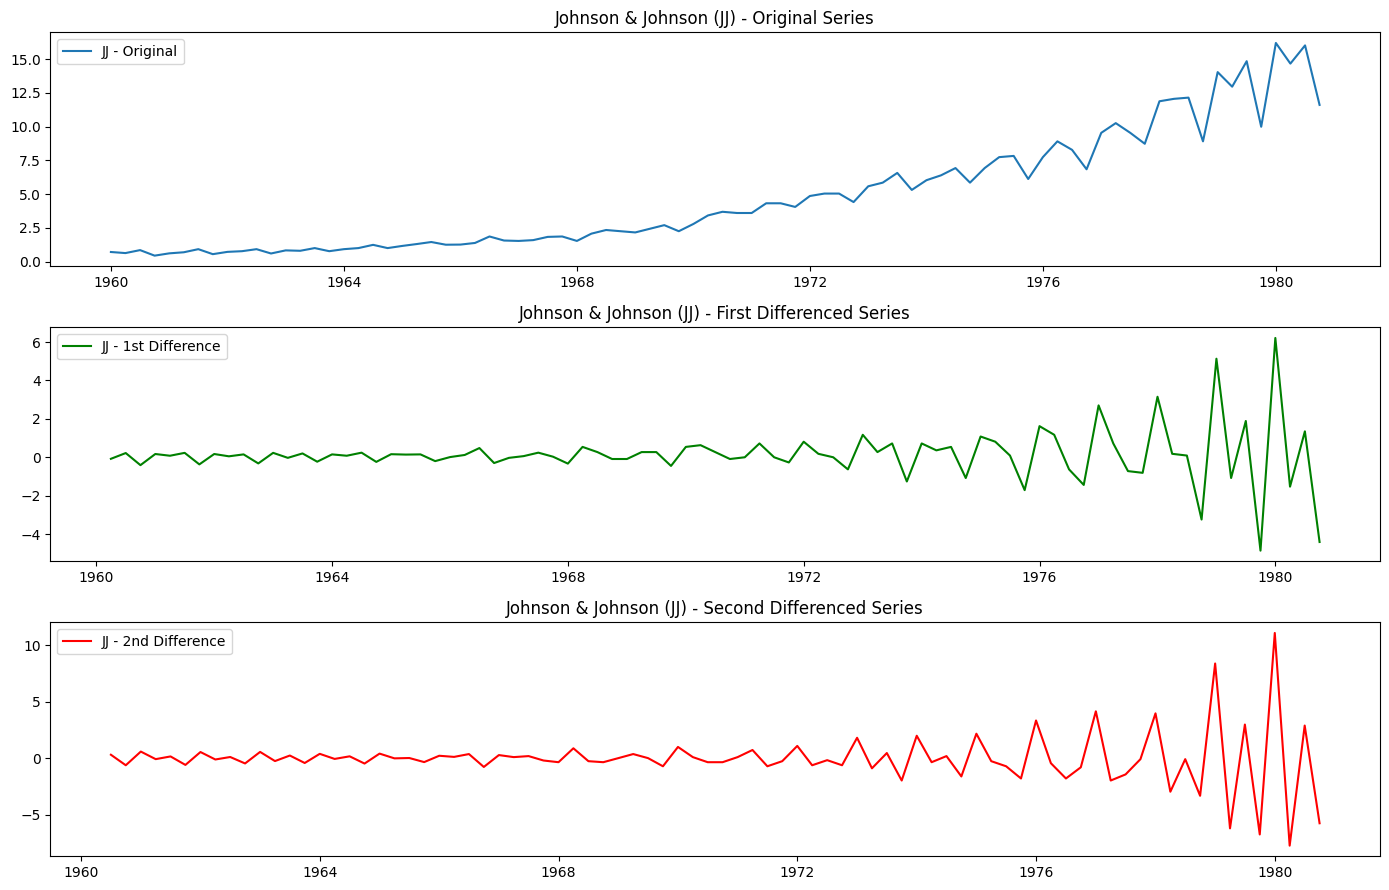

In [ ]:
import matplotlib.pyplot as plt

# Plot original and differenced series for AMZN
plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
plt.plot(amzn_series, label='AMZN - Original')
plt.title("Amazon (AMZN) - Original Series")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(amzn_diff, label='AMZN - 1st Difference', color='orange')
plt.title("Amazon (AMZN) - First Differenced Series")
plt.legend()
plt.tight_layout()
plt.show()

# Plot original and differenced series for JJ
plt.figure(figsize=(14, 9))
plt.subplot(3, 1, 1)
plt.plot(jj_series, label='JJ - Original')
plt.title("Johnson & Johnson (JJ) - Original Series")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(jj_diff, label='JJ - 1st Difference', color='green')
plt.title("Johnson & Johnson (JJ) - First Differenced Series")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(jj_diff2, label='JJ - 2nd Difference', color='red')
plt.title("Johnson & Johnson (JJ) - Second Differenced Series")
plt.legend()
plt.tight_layout()
plt.show()

# **Arima Model**

In [ ]:

# Extract target series
amzn_series = amzn_df['Close'].dropna()
jj_series = jj_df['data'].dropna()

# Grid search function to find best ARIMA order
def find_best_arima(series, max_p=5, max_d=3, max_q=5):
    best_score, best_cfg = float("inf"), None
    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    model = ARIMA(series, order=(p, d, q)).fit()
                    forecast = model.predict(start=0, end=len(series)-1)
                    mse = mean_squared_error(series[d:], forecast[d:])
                    if mse < best_score:
                        best_score, best_cfg = mse, (p, d, q)
                except:
                    continue
    if best_cfg is None:
        best_cfg = (1, 1, 1)  # fallback
    return best_cfg, best_score

# Run grid search for both datasets
best_amzn_order, amzn_mse = find_best_arima(amzn_series)
best_jj_order, jj_mse = find_best_arima(jj_series)

(best_amzn_order, amzn_mse), (best_jj_order, jj_mse)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


(((5, 1, 5), 7.499293791637032), ((5, 1, 4), 0.1662699259795615))

# **Arima Forecast**

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/di

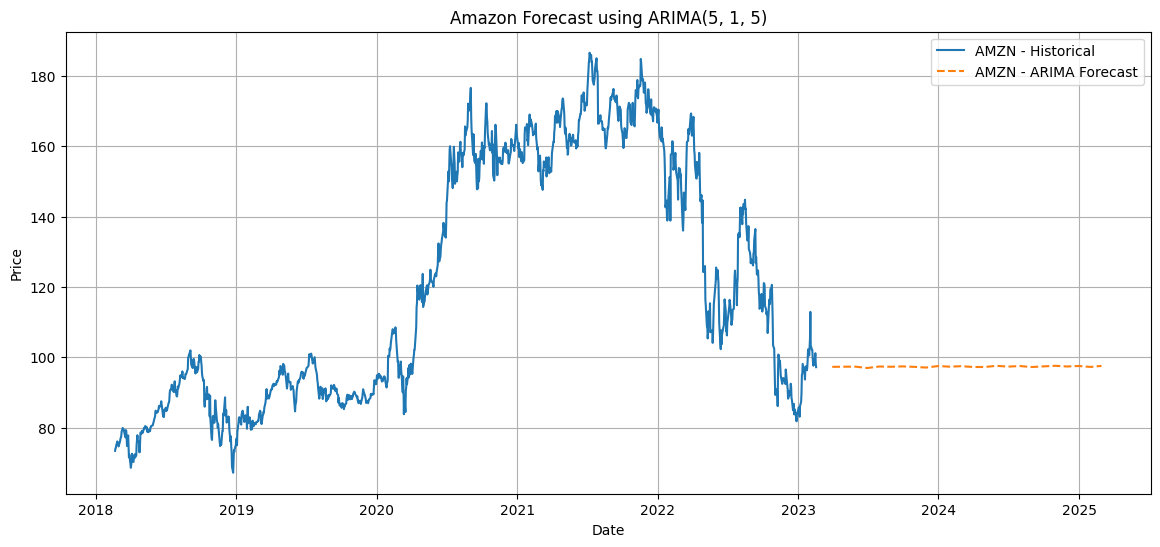

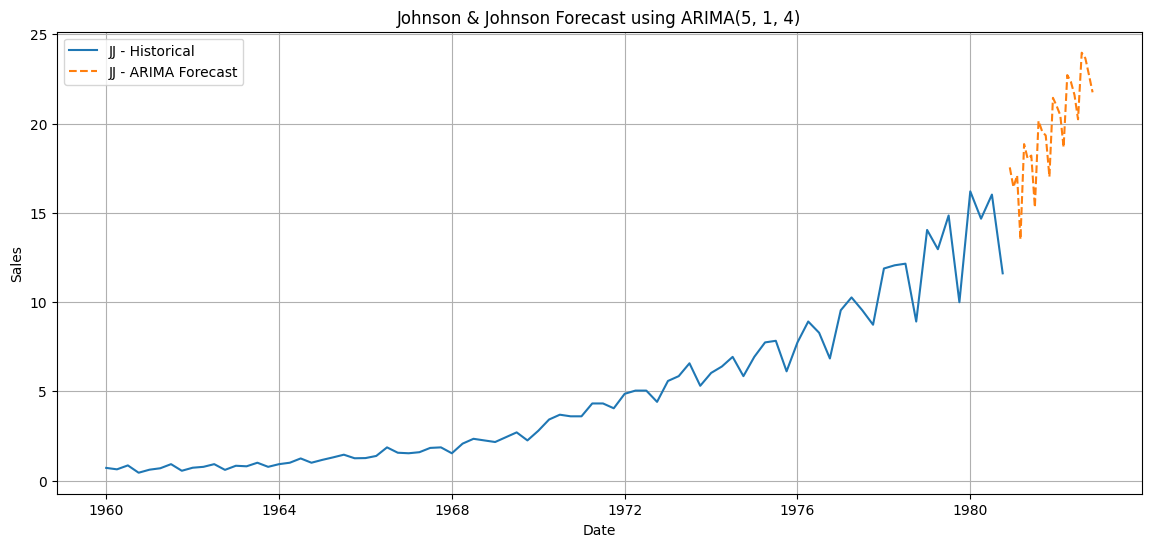

In [ ]:
# Fit final ARIMA models using best found parameters
amzn_model = ARIMA(amzn_series, order=best_amzn_order).fit()
jj_model = ARIMA(jj_series, order=best_jj_order).fit()

# Forecast next 24 months
amzn_forecast = amzn_model.forecast(steps=24)
jj_forecast = jj_model.forecast(steps=24)

# Generate forecast indices
amzn_forecast_index = pd.date_range(start=amzn_series.index[-1], periods=25, freq='M')[1:]
jj_forecast_index = pd.date_range(start=jj_series.index[-1], periods=25, freq='M')[1:]

# Plot Amazon forecast
plt.figure(figsize=(14, 6))
plt.plot(amzn_series, label='AMZN - Historical')
plt.plot(amzn_forecast_index, amzn_forecast, label='AMZN - ARIMA Forecast', linestyle='--')
plt.title(f"Amazon Forecast using ARIMA{best_amzn_order}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# Plot JJ forecast
plt.figure(figsize=(14, 6))
plt.plot(jj_series, label='JJ - Historical')
plt.plot(jj_forecast_index, jj_forecast, label='JJ - ARIMA Forecast', linestyle='--')
plt.title(f"Johnson & Johnson Forecast using ARIMA{best_jj_order}")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()

# **RNN model implementation**

In [ ]:
# Function to prepare LSTM sequences
def prepare_lstm_data(series, window_size=12):
    scaler = MinMaxScaler()
    scaled_series = scaler.fit_transform(series.values.reshape(-1, 1))

    X, y = [], []
    for i in range(window_size, len(scaled_series)):
        X.append(scaled_series[i-window_size:i])
        y.append(scaled_series[i])
    X, y = np.array(X), np.array(y)
    return X, y, scaler

# Function to train LSTM
def train_lstm(X, y, epochs=50, batch_size=8):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(X.shape[1], 1)))
    model.add(LSTM(32))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)
    return model

# Forecast next steps using trained model
def forecast_lstm(model, last_window, scaler, steps=24):
    forecast = []
    input_seq = last_window.copy()
    for _ in range(steps):
        pred = model.predict(input_seq.reshape(1, input_seq.shape[0], 1), verbose=0)
        forecast.append(pred[0][0])
        input_seq = np.append(input_seq[1:], pred, axis=0)
    forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1)).flatten()
    return forecast

# Set window size
window_size = 12

# --- AMZN ---
X_amzn, y_amzn, scaler_amzn = prepare_lstm_data(amzn_series, window_size)
lstm_model_amzn = train_lstm(X_amzn, y_amzn)
amzn_lstm_forecast = forecast_lstm(lstm_model_amzn, X_amzn[-1], scaler_amzn, steps=24)

# --- JJ ---
X_jj, y_jj, scaler_jj = prepare_lstm_data(jj_series, window_size)
lstm_model_jj = train_lstm(X_jj, y_jj)
jj_lstm_forecast = forecast_lstm(lstm_model_jj, X_jj[-1], scaler_jj, steps=24)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Function to train GRU
def train_gru(X, y, epochs=50, batch_size=8):
    model = Sequential()
    model.add(GRU(64, return_sequences=True, input_shape=(X.shape[1], 1)))
    model.add(GRU(32))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)
    return model

# Forecast with GRU
def forecast_gru(model, last_window, scaler, steps=24):
    forecast = []
    input_seq = last_window.copy()
    for _ in range(steps):
        pred = model.predict(input_seq.reshape(1, input_seq.shape[0], 1), verbose=0)
        forecast.append(pred[0][0])
        input_seq = np.append(input_seq[1:], pred, axis=0)
    forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1)).flatten()
    return forecast

# Train GRU models
gru_model_amzn = train_gru(X_amzn, y_amzn)
amzn_gru_forecast = forecast_gru(gru_model_amzn, X_amzn[-1], scaler_amzn)

gru_model_jj = train_gru(X_jj, y_jj)
jj_gru_forecast = forecast_gru(gru_model_jj, X_jj[-1], scaler_jj)


# **Forecasting 24 month next and Evalute model performence**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a suppo

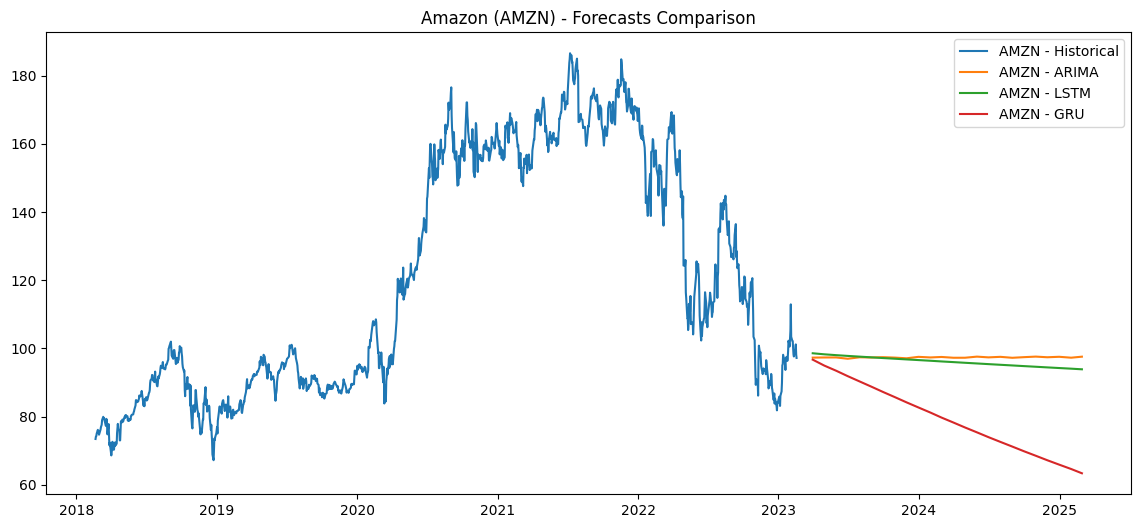

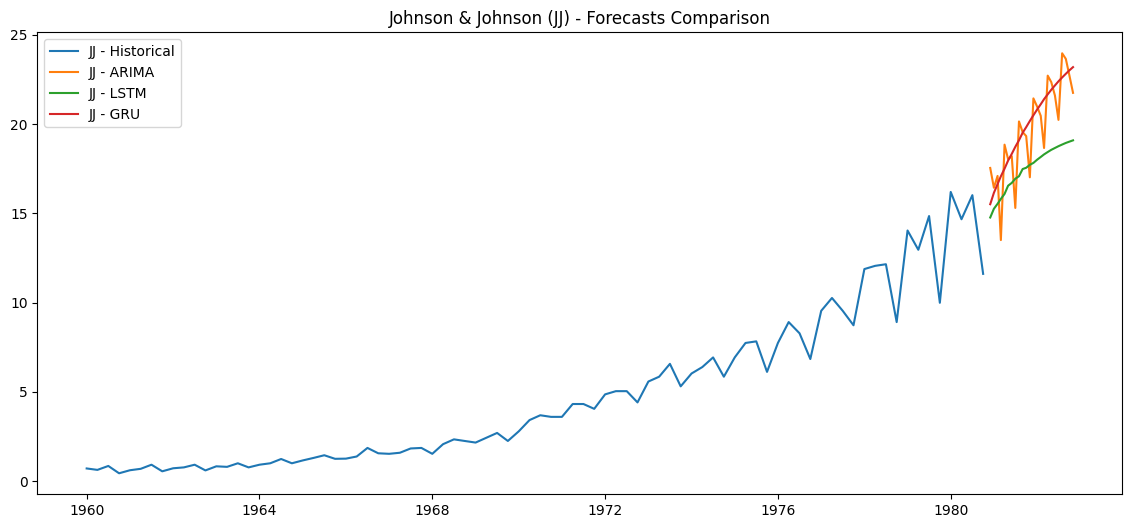

,Model,MSE,RMSE,MAE
0,AMZN_ARIMA,21.206891,4.605094,3.168560
1,AMZN_LSTM,34.004983,5.831379,4.674358
2,AMZN_GRU,558.982256,23.642806,20.553355
3,JJ_ARIMA,83.638269,9.145396,9.074699
4,JJ_LSTM,52.237388,7.227544,6.929327
5,JJ_GRU,91.618529,9.571757,9.429621


In [ ]:

# Forecast from ARIMA models
amzn_arima_forecast = amzn_model.forecast(steps=24)
jj_arima_forecast = jj_model.forecast(steps=24)

# Forecast dates
amzn_forecast_dates = pd.date_range(amzn_series.index[-1], periods=25, freq='M')[1:]
jj_forecast_dates = pd.date_range(jj_series.index[-1], periods=25, freq='M')[1:]

# Plotting for AMZN
plt.figure(figsize=(14, 6))
plt.plot(amzn_series, label='AMZN - Historical')
plt.plot(amzn_forecast_dates, amzn_arima_forecast, label='AMZN - ARIMA')
plt.plot(amzn_forecast_dates, amzn_lstm_forecast, label='AMZN - LSTM')
plt.plot(amzn_forecast_dates, amzn_gru_forecast, label='AMZN - GRU')
plt.title("Amazon (AMZN) - Forecasts Comparison")
plt.legend()
plt.show()

# Plotting for JJ
plt.figure(figsize=(14, 6))
plt.plot(jj_series, label='JJ - Historical')
plt.plot(jj_forecast_dates, jj_arima_forecast, label='JJ - ARIMA')
plt.plot(jj_forecast_dates, jj_lstm_forecast, label='JJ - LSTM')
plt.plot(jj_forecast_dates, jj_gru_forecast, label='JJ - GRU')
plt.title("Johnson & Johnson (JJ) - Forecasts Comparison")
plt.legend()
plt.show()

# Evaluation on last known 24 points
def evaluate(true_vals, predicted_vals):
    mse = mean_squared_error(true_vals, predicted_vals)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_vals, predicted_vals)
    return mse, rmse, mae

# Actual values (ground truth)
amzn_true = amzn_series[-24:]
jj_true = jj_series[-24:]

# Truncate forecasts to same length for metrics
amzn_arima_metrics = evaluate(amzn_true, amzn_arima_forecast[:24])
amzn_lstm_metrics = evaluate(amzn_true, amzn_lstm_forecast[:24])
amzn_gru_metrics = evaluate(amzn_true, amzn_gru_forecast[:24])

jj_arima_metrics = evaluate(jj_true, jj_arima_forecast[:24])
jj_lstm_metrics = evaluate(jj_true, jj_lstm_forecast[:24])
jj_gru_metrics = evaluate(jj_true, jj_gru_forecast[:24])

# Create DataFrame of results
metrics_df = pd.DataFrame({
    'Model': ['AMZN_ARIMA', 'AMZN_LSTM', 'AMZN_GRU', 'JJ_ARIMA', 'JJ_LSTM', 'JJ_GRU'],
    'MSE': [*amzn_arima_metrics[0:1], *amzn_lstm_metrics[0:1], *amzn_gru_metrics[0:1],
            *jj_arima_metrics[0:1], *jj_lstm_metrics[0:1], *jj_gru_metrics[0:1]],
    'RMSE': [*amzn_arima_metrics[1:2], *amzn_lstm_metrics[1:2], *amzn_gru_metrics[1:2],
             *jj_arima_metrics[1:2], *jj_lstm_metrics[1:2], *jj_gru_metrics[1:2]],
    'MAE': [*amzn_arima_metrics[2:], *amzn_lstm_metrics[2:], *amzn_gru_metrics[2:],
            *jj_arima_metrics[2:], *jj_lstm_metrics[2:], *jj_gru_metrics[2:]]
})

metrics_df
